In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

In [4]:
df = pd.read_csv('D:/newz/news.csv')

In [36]:
print(df.shape)
df.head(15)

(6335, 5)


,Unnamed: 0,title,text,label,text_length
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,7518
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,2646
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,2543
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,2660
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1840
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE,13333
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE,3171
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL,783
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL,13863
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL,4296


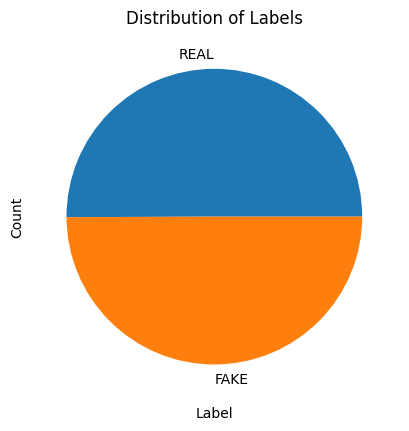

In [17]:
# EDA for label distribution
df['label'].value_counts().plot(kind='pie', color=['skyblue', 'salmon'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


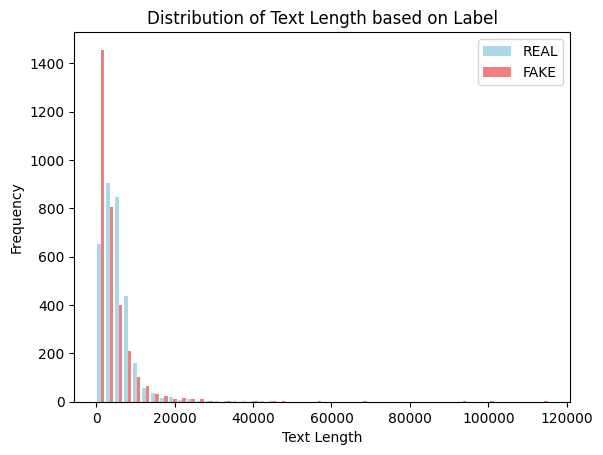

In [19]:
# EDA for text length distribution based on label
plt.hist([df[df['label'] == 'REAL']['text_length'], df[df['label'] == 'FAKE']['text_length']],
         bins=50, color=['lightblue', 'lightcoral'], label=['REAL', 'FAKE'])
plt.title('Distribution of Text Length based on Label')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [21]:
# Split the data into training and testing sets
labels = df.label
x_train, x_test, y_train, y_test = train_test_split(df['text'], labels, test_size=0.2, random_state=7)

In [22]:
# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_test = tfidf_vectorizer.transform(x_test)

In [23]:
# Train a Passive Aggressive Classifier
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train, y_train)


PassiveAggressiveClassifier(max_iter=50)

In [25]:
# Evaluate the model using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pac_cv = PassiveAggressiveClassifier(max_iter=50)
cv_scores = cross_val_score(pac_cv, tfidf_train, y_train, cv=cv, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Accuracy: {np.mean(cv_scores)}')

Cross-Validation Scores: [0.93293886 0.9270217  0.93688363 0.94274432 0.94471866]
Mean Accuracy: 0.9368614325406792


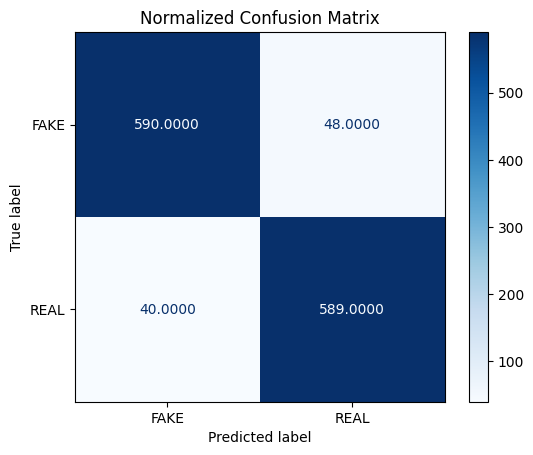

In [26]:
# Plot confusion matrix
y_test_bin = label_binarize(y_test, classes=['FAKE', 'REAL'])
y_pred = pac.predict(tfidf_test)
cm = confusion_matrix(y_test, y_pred, labels=['FAKE', 'REAL'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE', 'REAL'])
disp.plot(cmap=plt.cm.Blues, values_format=".4f")
disp.ax_.set_title('Normalized Confusion Matrix')
plt.show()

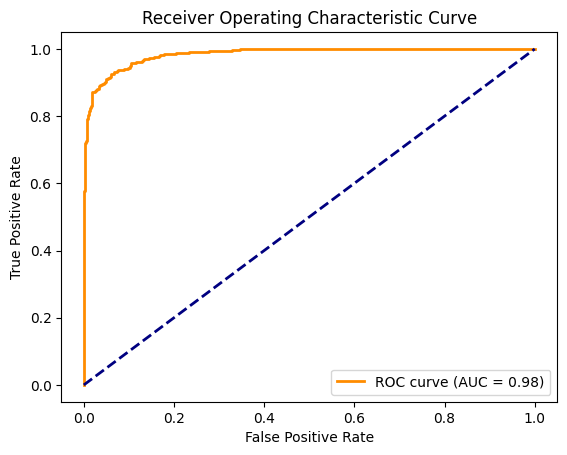

In [30]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_bin, pac.decision_function(tfidf_test))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

In [31]:
# Display the accuracy score
y_pred = pac.predict(tfidf_test)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score * 100, 2)}% with this model')

Accuracy: 93.05% with this model


In [33]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'C': [0.1, 1, 10, 100],
              'max_iter': [50, 100, 200]}

# Create the grid search object
grid_search = GridSearchCV(estimator=PassiveAggressiveClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(tfidf_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 0.1, 'max_iter': 100}


In [34]:
# Predict on the test set
y_pred = grid_search.predict(tfidf_test)

# Create a DataFrame for error analysis
error_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Text': x_test, 'Text_Length': x_test.apply(len)})

# Display instances where the model made errors
error_df[error_df['Actual'] != error_df['Predicted']]


,Actual,Predicted,Text,Text_Length
351,REAL,FAKE,The federal government must make regular inter...,1537
1328,FAKE,REAL,Reinventing Democracy in America Starts by Vot...,7709
2215,FAKE,REAL,Does anyone like Trump as a person ? The answe...,1073
3351,REAL,FAKE,"Asked what Trump will do while in Florida, spo...",152
187,REAL,FAKE,A recent draft of the Trans-Pacific Partnershi...,9194
...,...,...,...,...
5887,FAKE,REAL,Home › POLITICS | US NEWS › 8 POINTS VANISH IN...,1795
243,REAL,FAKE,The United States comes up constantly when you...,7310
3549,FAKE,REAL,Actor Jim Caviezel portraying Jesus in “The Pa...,3644
4645,REAL,FAKE,Arab leaders have been pressing the Obama admi...,196


In [35]:
# Use StratifiedKFold for cross-validation
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_stratified = cross_val_score(grid_search.best_estimator_, tfidf_train, y_train, cv=cv_stratified, scoring='accuracy')

print(f'Cross-Validation Scores (Stratified K-Fold): {cv_scores_stratified}')
print(f'Mean Accuracy (Stratified K-Fold): {np.mean(cv_scores_stratified)}')


Cross-Validation Scores (Stratified K-Fold): [0.93688363 0.92406312 0.93885602 0.94373149 0.94570582]
Mean Accuracy (Stratified K-Fold): 0.9378480152494884
